In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import exposure
import glob
#show matplot images inline
%matplotlib inline

# Get images

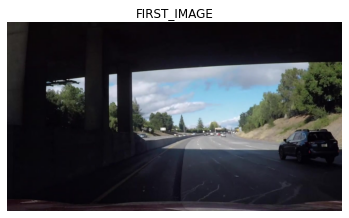

In [11]:
def show_image(image,title="image",cmap_type="gray"):
    plt.imshow(image,cmap_type)
    plt.title(title)
    plt.axis("off")
#LOADING ALL IMAGES FROM TEST_IMAGES FILE
images = glob.glob("test_images/*.jpg")
images = [plt.imread(image) for image in images] 

show_image(images[0],"FIRST_IMAGE")

# Helper Functions

In [12]:
##ZIAD 
def gaussian_blur(img,kernel_size):
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),#5x5 I guess
                  0)
def pipeline(img):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
#     s_channel = hls[:,:,2]
#     h_channel = hls[:,:,0]
#     v_channel= hsv[:,:,2]
    return l_channel

In [13]:
##Omar
def perspective_transform(img,dst_size=(1280,720),inv=0):
    img_size=np.float32([(img.shape[1],img.shape[0])])
    #Region of Interest
    #Order is top left, top right, bottom left, bottom right
    src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])
    dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])
    srcPoints = src*img_size
    dstPoints = dst*np.float32(dst_size)
    if(inv):
        M = cv2.getPerspectiveTransform(dstPoints,srcPoints) #inverse
    else:
        M = cv2.getPerspectiveTransform(srcPoints,dstPoints) #Returns a matrix that transforms an Image
    warped_image = cv2.warpPerspective(img,M,dst_size)
    return warped_image 
# Histogram Equalizer
def hist_equalizer(img):
    pass

In [14]:
##Fady
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist
def filter_lane_lines(img):
    img = gaussian_blur(img,5)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(27,27))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    mask = np.zeros_like(tophat)
#     mask[((tophat > 10)&(tophat<=150))] = 1 #Thresholding
    mask = cv2.threshold(tophat, 10, 255, cv2.THRESH_BINARY)[1]
    kernel = np.ones((13,13),np.uint8)
    mask = cv2.dilate(mask,kernel,iterations = 1)
    kernel = np.ones((10,5),np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 1)
    return mask

Text(0.5, 1.0, 'Lane detection')

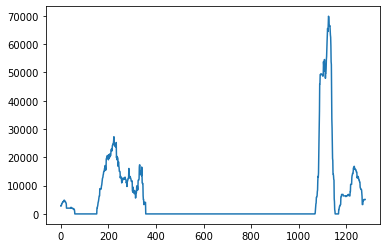

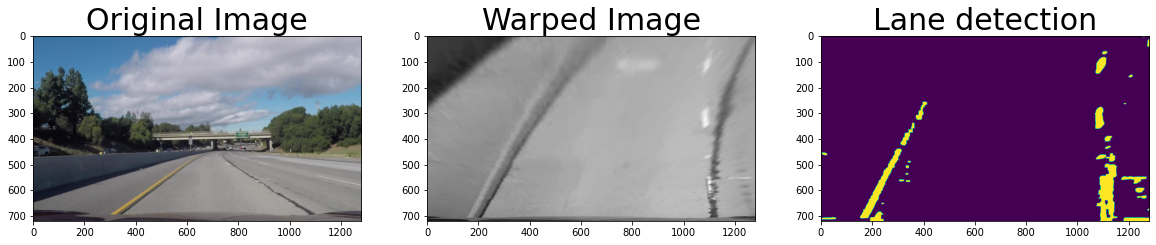

In [15]:
img = images[2]
# img = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
img1 = pipeline(img)
warped_image = perspective_transform(img1, dst_size=(1280,720),inv=0)
lane_detection = filter_lane_lines(warped_image)
histogram = get_hist(lane_detection)
# show_image(mask)
plt.plot(histogram)
# plotting
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)
ax3.imshow(lane_detection)
ax3.set_title('Lane detection', fontsize=30)


# Sliding Window